# Modified IQAE tests

In [1]:
import matplotlib.pyplot as plt
import numpy as np

from random import sample, seed
from collections import defaultdict

from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, Aer, transpile, assemble
from qiskit.algorithms import amplitude_estimators, EstimationProblem
from qiskit.algorithms import IterativeAmplitudeEstimation as BaseIterativeAmplitudeEstimation

from algorithms import IterativeAmplitudeEstimation, ModifiedIterativeAmplitudeEstimation
from algorithms import NoQuantumIterativeAmplitudeEstimation
from operators import *

In [2]:
# for setting a single amplitude, below automates this for arbirtrary numbers of amplitudes
n = 4
N = 2**n
k = N//2
marked = sample(range(N), k)

In [3]:
# Define the estimation problem and oracle function
def make_problems(n, marked):
    
    def good_state(state):
        bin_marked = [(n-len(bin(s))+2)*'0'+bin(s)[2:] for s in marked]
        return (state in bin_marked)

    problem = EstimationProblem(
        state_preparation=A(n),  # A operator
        grover_operator=Q(n, marked),  # Q operator
        objective_qubits=range(n),
        is_good_state=good_state  # the "good" state Psi1 is identified as measuring |1> in qubit 0
    )

    problem2 = EstimationProblem(
        state_preparation=A(n),  # A operator
        grover_operator=Q(n, marked),  # Q operator
        objective_qubits=range(n),
        is_good_state=good_state  # the "good" state Psi1 is identified as measuring |1> in qubit 0
    )
    
    return problem, problem2

In [4]:
# use local simulator
aer_sim = Aer.get_backend('aer_simulator')
shots = 128

## Compare Modified IQAE to No-Quantum IQAE

In [5]:
# parameters for IQAE

# amplitudes
n = 4
k = 2**n

# epsilons
powers = range(2,7)
epsilons = [(1.0 / (10**power)) for power in powers]

# other
alpha = 0.05
confint_method = 'chernoff'
verbose = False

a: 0/16 = 0.0
Modified IAE estimations: [0.00018629109633528127, 1.9858904912804507e-06, 1.8326328851027684e-08, 1.8602766260894983e-10, 3.5449724799294457e-13]
Fixed Original IAE estimations: [0.0001708664274156844, 9.865249172817861e-07, 6.663619444287578e-09, 5.7065764415064465e-11, 4.2021269411237273e-13]
Modified IAE total queries: 103532288
Fixed Original IAE total queries: 91604096
Modified IAE epsilons: [0.00018629109633528127, 1.9858904912804507e-06, 1.8326328851027684e-08, 1.8602766260894983e-10, 3.5449724799294457e-13]
Fixed Original IAE epsilons: [0.0001708664274156844, 9.865249172817861e-07, 6.663619444287578e-09, 5.7065764415064465e-11, 4.2021269411237273e-13]
Modified wins? True with 11.52% difference


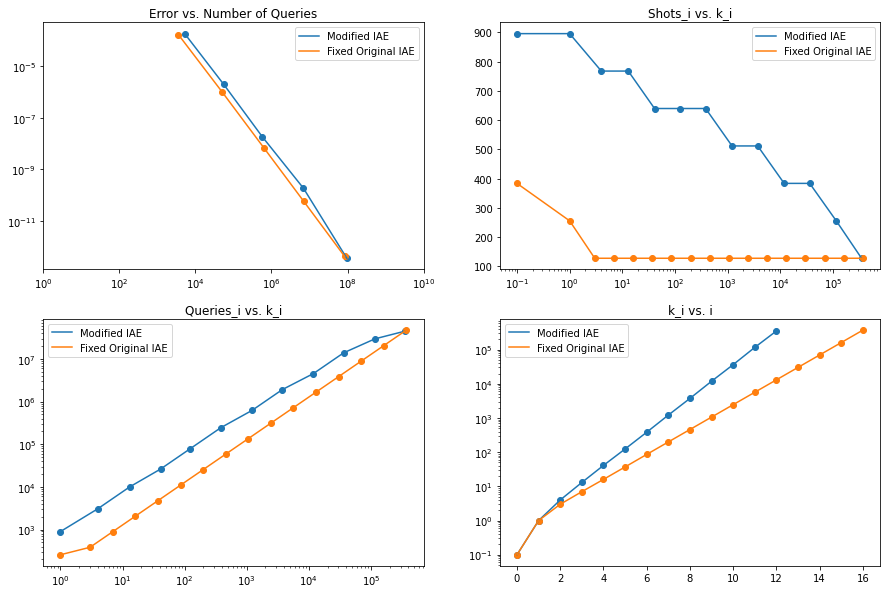

a: 1/16 = 0.0625
Modified IAE estimations: [0.06194152610419655, 0.06251867138866418, 0.06250934607968986, 0.062499956759235316, 0.06250000319748292]
Fixed Original IAE estimations: [0.06208056250186278, 0.0625376378940408, 0.06248428781045787, 0.06250023415439855, 0.062499991032002926]
Modified IAE total queries: 68997248
Fixed Original IAE total queries: 92278144
Modified IAE epsilons: [0.0044549739342138635, 0.00042781120538172915, 3.310422634590984e-05, 4.791665170984782e-06, 4.0353193934278275e-07]
Fixed Original IAE epsilons: [0.003704213533464649, 0.00044748710932141986, 4.6763545252587885e-05, 3.7156525241853477e-06, 3.6102374307428464e-07]
Modified wins? False with 33.74% difference


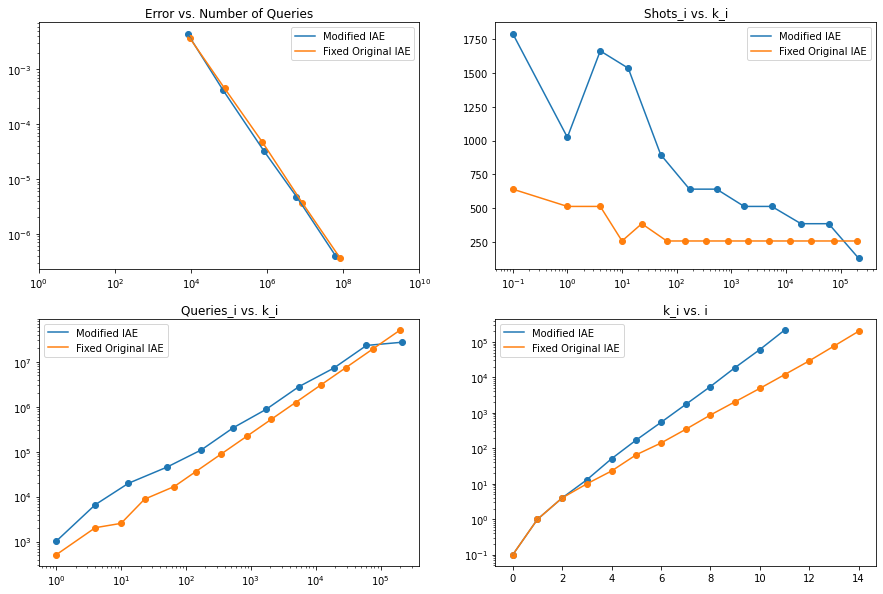

a: 2/16 = 0.125
Modified IAE estimations: [0.12391638920049504, 0.12495417629001987, 0.1250169709750633, 0.12499954229594717, 0.1249999466936206]
Fixed Original IAE estimations: [0.12374189856320636, 0.12501882801472672, 0.1249929001975128, 0.1249999975805652, 0.12499991287396384]
Modified IAE total queries: 67776000
Fixed Original IAE total queries: 93032832
Modified IAE epsilons: [0.004269289565962661, 0.0006161843161991212, 5.051851745416919e-05, 6.292835190220558e-06, 6.032955565671294e-07]
Fixed Original IAE epsilons: [0.00469684723725617, 0.00038663795571878407, 4.673570098631674e-05, 4.034668950672615e-06, 5.190777205843489e-07]
Modified wins? False with 37.27% difference


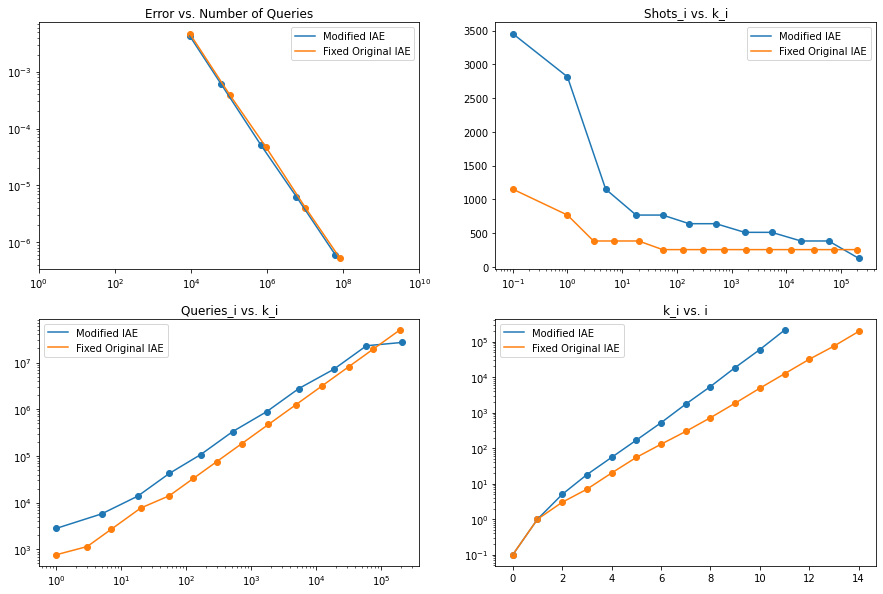

a: 3/16 = 0.1875
Modified IAE estimations: [0.18803376540731298, 0.18771086277754773, 0.18748964473194185, 0.18750078592968972, 0.18750000183154958]
Fixed Original IAE estimations: [0.18614650265656146, 0.1876069467776041, 0.18750637930037212, 0.18199143250876856, 0.1874999144674886]
Modified IAE total queries: 78275200
Fixed Original IAE total queries: 115512832
Modified IAE epsilons: [0.007363537044902335, 0.00047946648938551606, 7.087715808365425e-05, 6.963139125890083e-06, 5.812542318017755e-07]
Fixed Original IAE epsilons: [0.007004881586442371, 0.0007589786669736781, 6.409586225238073e-05, 5.9826420621411636e-06, 5.615159159172434e-07]
Modified wins? False with 47.57% difference


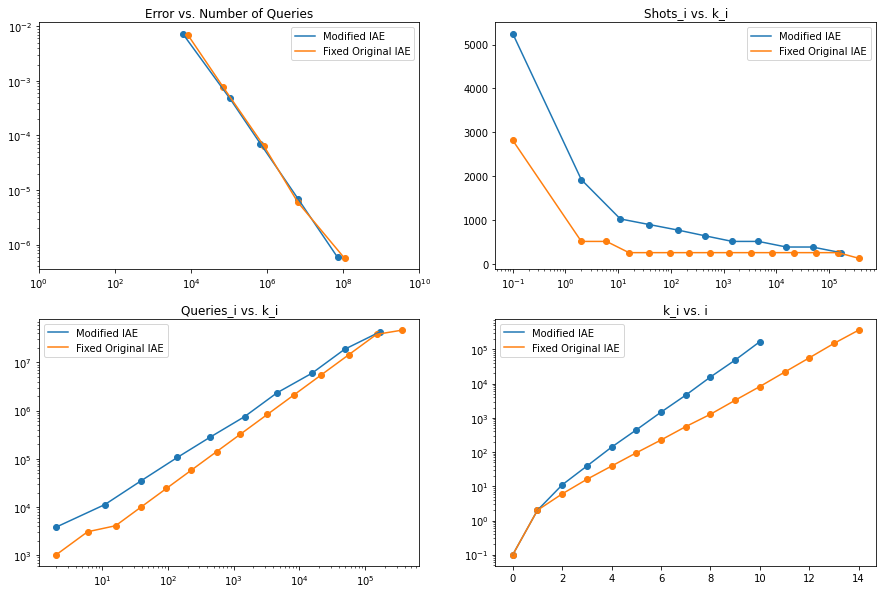

a: 4/16 = 0.25
Modified IAE estimations: [0.25054914641650994, 0.2498546336594663, 0.250004993058426, 0.24999850827948492, 0.24999979798949729]
Fixed Original IAE estimations: [0.25104494313022185, 0.2500196801385511, 0.25002355351850747, 0.2500000073919053, 0.2500002159208472]
Modified IAE total queries: 145372672
Fixed Original IAE total queries: 146749184
Modified IAE epsilons: [0.008629636269894908, 0.0006741665523473245, 7.999060177628359e-05, 7.020683842368092e-06, 6.904117657580144e-07]
Fixed Original IAE epsilons: [0.007558955504405607, 0.0005630522728447412, 8.043209703087473e-05, 6.586623313417639e-06, 8.111672509525381e-07]
Modified wins? False with 0.95% difference


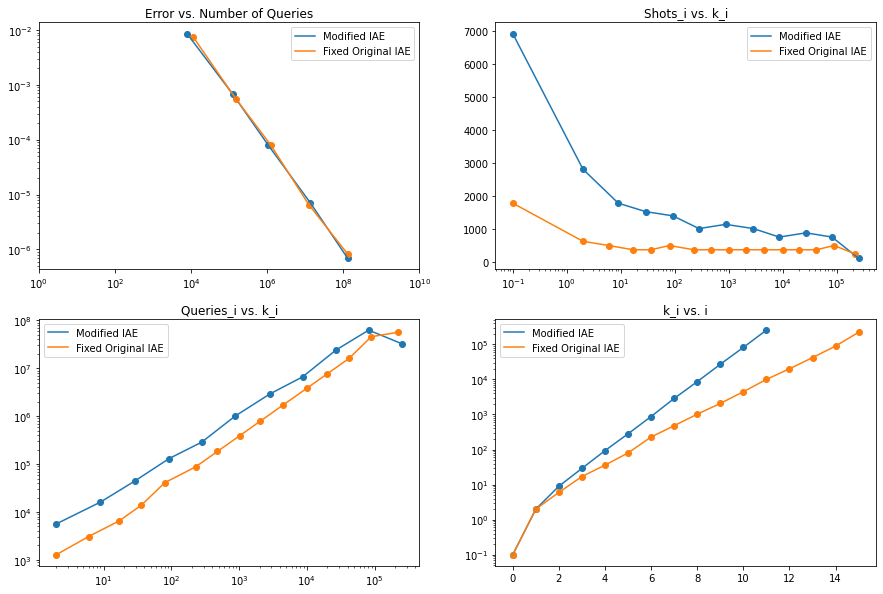

a: 5/16 = 0.3125
Modified IAE estimations: [0.3130858452894518, 0.31256386250574925, 0.3124987434210686, 0.3124993551418043, 0.31250003147206307]
Fixed Original IAE estimations: [0.31269555425372925, 0.3125688687857465, 0.3124786260395138, 0.312500490727779, 0.3125001333215858]
Modified IAE total queries: 69679360
Fixed Original IAE total queries: 108194304
Modified IAE epsilons: [0.00789220542663413, 0.0007632891050208812, 5.9123020627660505e-05, 7.89422253749672e-06, 8.682048904251616e-07]
Fixed Original IAE epsilons: [0.006107448496000367, 0.0006502993122352585, 9.180392571805918e-05, 5.740701208234444e-06, 7.343400620918317e-07]
Modified wins? False with 55.27% difference


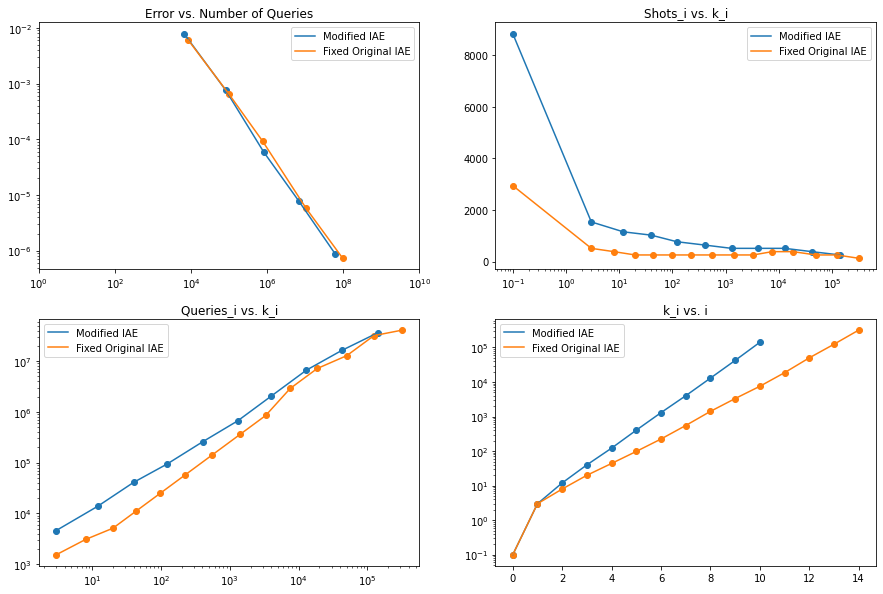

a: 6/16 = 0.375
Modified IAE estimations: [0.37571989847573417, 0.37515889716801243, 0.37498884639032726, 0.37500013049748926, 0.37500024011978483]
Fixed Original IAE estimations: [0.37459165228030256, 0.3750342693320122, 0.37497386382194214, 0.37500202550330414, 0.37500011940005706]
Modified IAE total queries: 71667072
Fixed Original IAE total queries: 115826048
Modified IAE epsilons: [0.006694884751866748, 0.0008287043779060255, 8.785611182296482e-05, 9.240473709398733e-06, 7.988290298965861e-07]
Fixed Original IAE epsilons: [0.009309004674060511, 0.0007918396514697001, 7.492320278518205e-05, 8.743397719224166e-06, 7.01767450234092e-07]
Modified wins? False with 61.62% difference


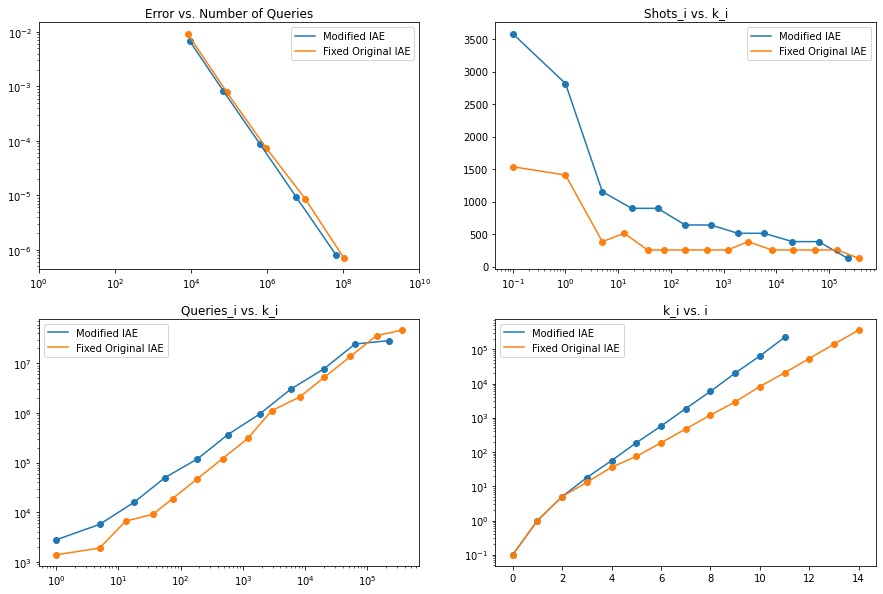

a: 7/16 = 0.4375
Modified IAE estimations: [0.4375685829105873, 0.4375827622356977, 0.43747495944734616, 0.43749998891652575, 0.4374999952157864]
Fixed Original IAE estimations: [0.4365975040057648, 0.4377005416557779, 0.437511297409109, 0.4374985675167308, 0.43750014223182687]
Modified IAE total queries: 75661824
Fixed Original IAE total queries: 101019776
Modified IAE epsilons: [0.008335625994561696, 0.0009154800815836805, 9.675520838975382e-05, 8.257606996325828e-06, 8.643101269967257e-07]
Fixed Original IAE epsilons: [0.007754923142407416, 0.0007353170004928411, 8.060296065973138e-05, 9.724583311582213e-06, 6.858221428263089e-07]
Modified wins? False with 33.51% difference


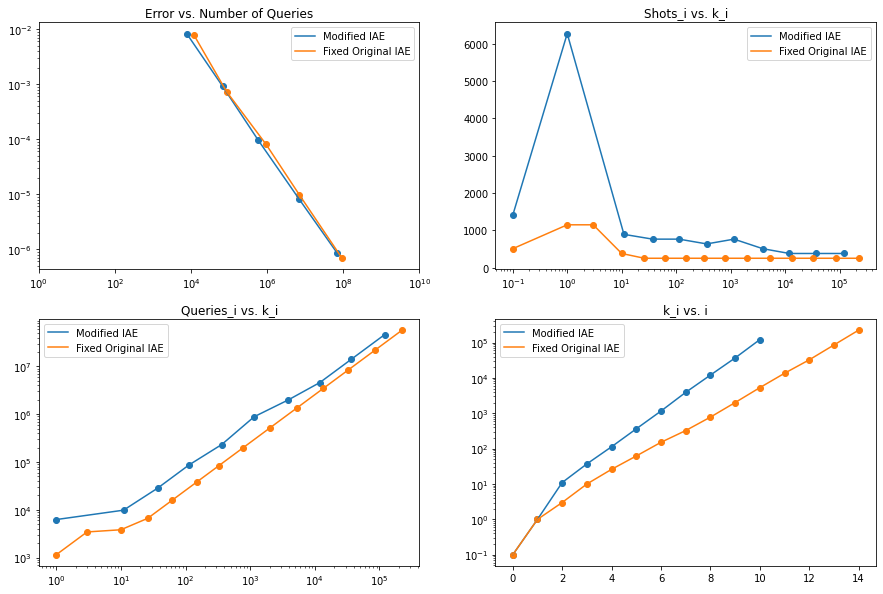

a: 8/16 = 0.5
Modified IAE estimations: [0.4986043381718579, 0.49985756045178775, 0.5000082691240754, 0.4999984490168593, 0.5000000603233481]
Fixed Original IAE estimations: [0.49888987626133896, 0.5001801691277319, 0.4999975844513611, 0.49999817327391194, 0.4999998802078688]
Modified IAE total queries: 79333504
Fixed Original IAE total queries: 95349376
Modified IAE epsilons: [0.008909323890189641, 0.0007995815012459273, 9.217738983291479e-05, 9.991798412128938e-06, 8.507598402984762e-07]
Fixed Original IAE epsilons: [0.007321293263238965, 0.0008035036183008937, 8.671046348410205e-05, 8.80382073289998e-06, 7.560423523900184e-07]
Modified wins? False with 20.19% difference


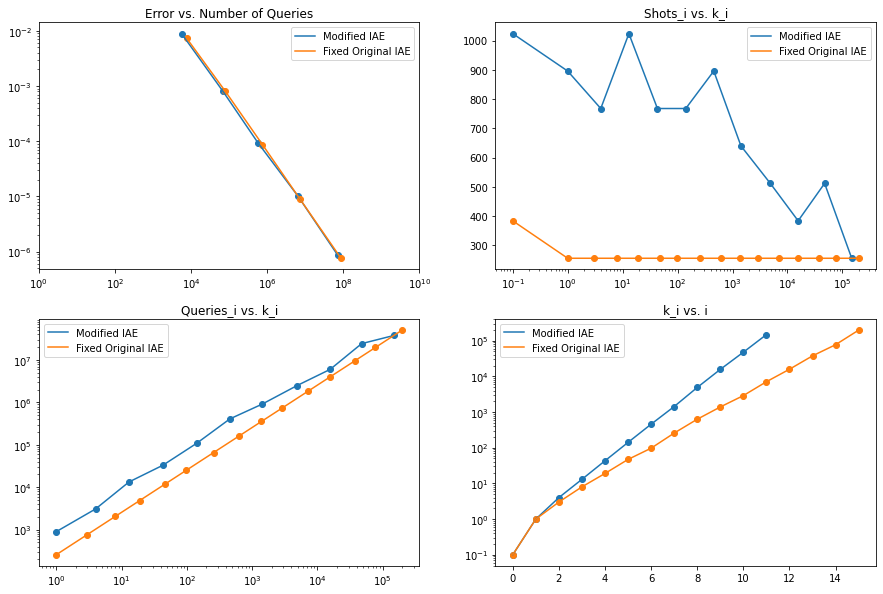

a: 9/16 = 0.5625
Modified IAE estimations: [0.5610983410818471, 0.5623417492625356, 0.562497635697759, 0.5620927778263871, 0.5624998263936213]
Fixed Original IAE estimations: [0.5631438074794266, 0.5624821188354867, 0.5624895355180812, 0.5624992096452557, 0.5624996771805129]
Modified IAE total queries: 69890560
Fixed Original IAE total queries: 85726208
Modified IAE epsilons: [0.009673113397580702, 0.000911454598024275, 7.707441894277967e-05, 9.889323757950041e-06, 9.670086277280276e-07]
Fixed Original IAE epsilons: [0.00866579448921323, 0.0008554016028979872, 9.08393334675961e-05, 9.162330595557933e-06, 9.809238275537702e-07]
Modified wins? False with 22.66% difference


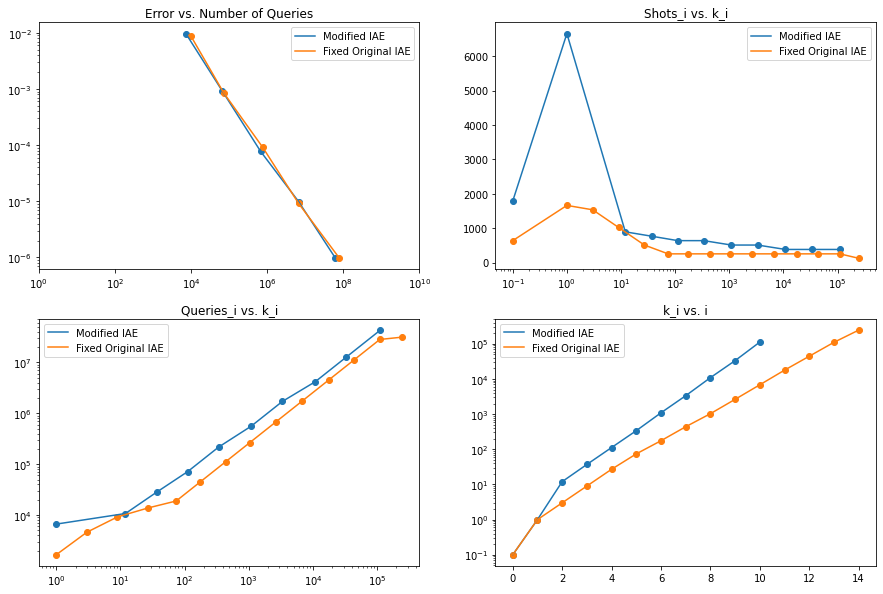

a: 10/16 = 0.625
Modified IAE estimations: [0.625789471753888, 0.6250633444455844, 0.6250175877486921, 0.6250013763371339, 0.6249999187774204]
Fixed Original IAE estimations: [0.624900909659287, 0.6249291891880577, 0.6250019948617862, 0.6249988987929438, 0.6015494215637408]
Modified IAE total queries: 76138880
Fixed Original IAE total queries: 103614208
Modified IAE epsilons: [0.007125179565397932, 0.0008248291902308025, 7.011947352358883e-05, 8.763898179164897e-06, 7.261145099080046e-07]
Fixed Original IAE epsilons: [0.007089153078540633, 0.0007110997959239307, 6.242554938745704e-05, 6.583181511310432e-06, 6.130073803012337e-07]
Modified wins? False with 36.09% difference


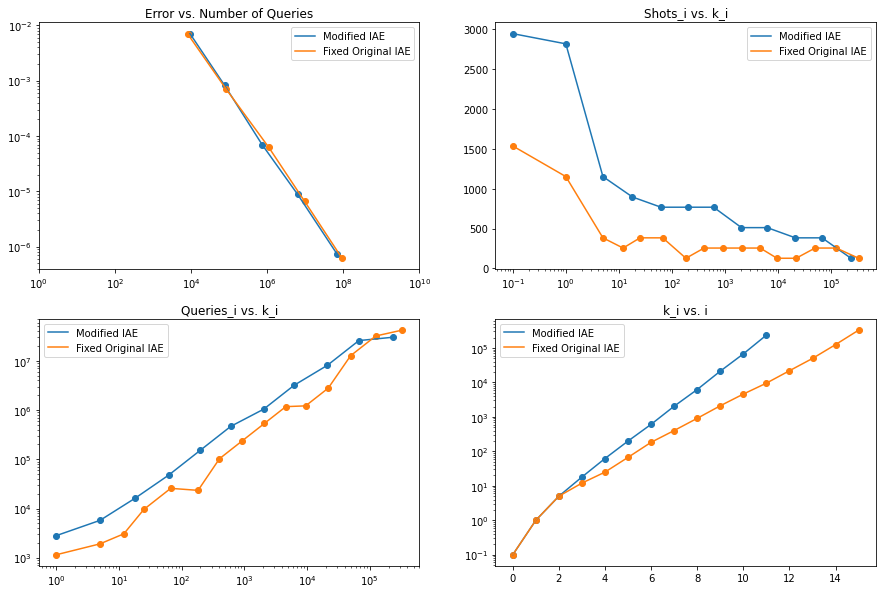

a: 11/16 = 0.6875
Modified IAE estimations: [0.6892230867589739, 0.68746259990299, 0.687496125687957, 0.6874995008922302, 0.6874999253881147]
Fixed Original IAE estimations: [0.6885056998429188, 0.6873163615217457, 0.6874797063654456, 0.6874994238420458, 0.6875000957982895]
Modified IAE total queries: 67118464
Fixed Original IAE total queries: 75554432
Modified IAE epsilons: [0.008111473734166541, 0.0007457903714791492, 7.347435656063217e-05, 8.164626495776872e-06, 8.363186688731261e-07]
Fixed Original IAE epsilons: [0.006619413547354069, 0.0008608119336684372, 8.755977758617695e-05, 8.388903605272002e-06, 8.953024774327467e-07]
Modified wins? False with 12.57% difference


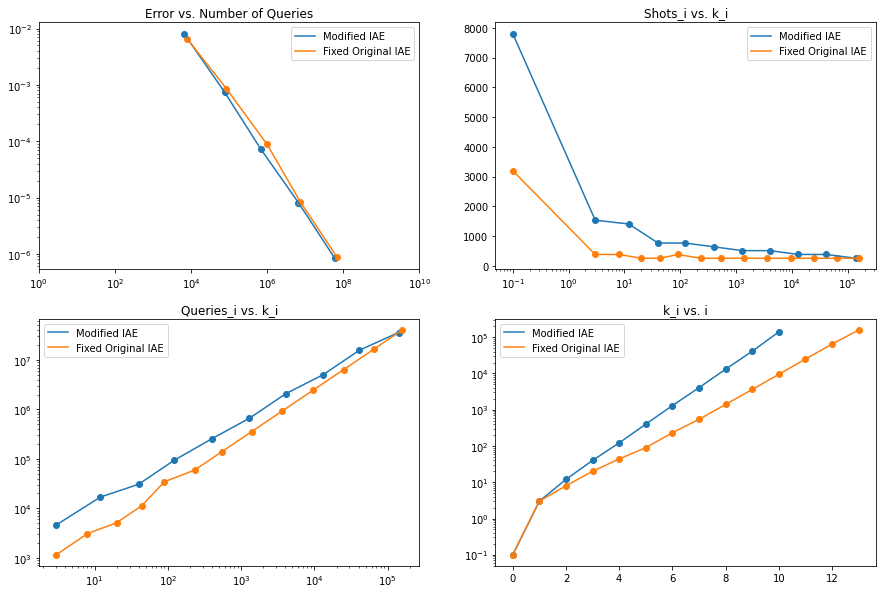

a: 12/16 = 0.75
Modified IAE estimations: [0.7501519329362977, 0.7500737442467014, 0.7500106370064377, 0.7500012153503455, 0.7499998274560224]
Fixed Original IAE estimations: [0.7502624393105901, 0.7500847454665502, 0.7500145435920714, 0.7500008793706666, 0.7499999914478896]
Modified IAE total queries: 130815232
Fixed Original IAE total queries: 114800768
Modified IAE epsilons: [0.007980400355617867, 0.0008359261854959943, 8.321659763677047e-05, 7.13619798009546e-06, 7.457114057918268e-07]
Fixed Original IAE epsilons: [0.005923266753621759, 0.0005336210784832596, 8.097377903670822e-05, 8.103515790613969e-06, 8.604755728502944e-07]
Modified wins? True with 12.24% difference


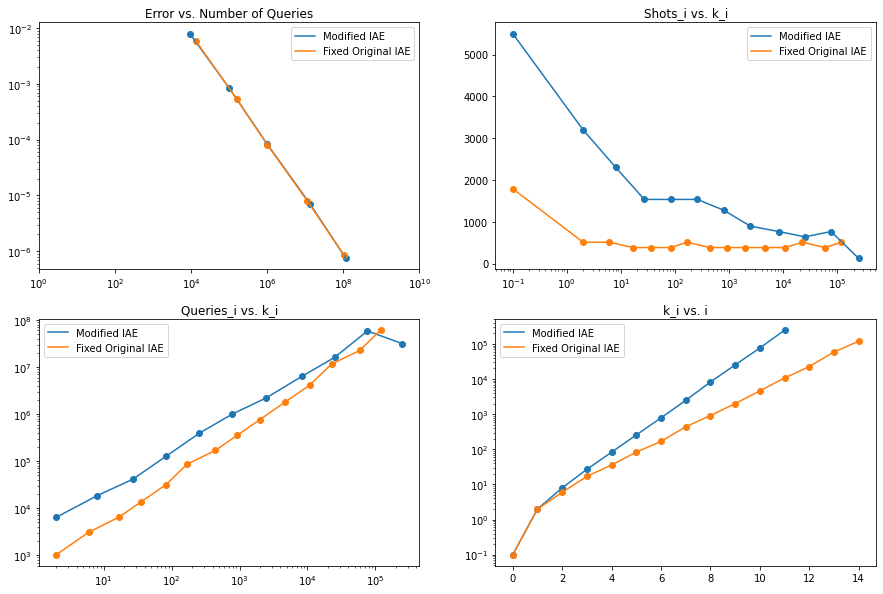

a: 13/16 = 0.8125
Modified IAE estimations: [0.8117642830540712, 0.8124678347558063, 0.8125111255841775, 0.812499157923517, 0.8125000192100154]
Fixed Original IAE estimations: [0.8119060070221146, 0.812427297191413, 0.8124983694599107, 0.8125015711210468, 0.81250021165051]
Modified IAE total queries: 107643392
Fixed Original IAE total queries: 90999552
Modified IAE epsilons: [0.007386896845348656, 0.0007090090516481129, 3.795109555154719e-05, 4.19662691630851e-06, 4.0051452532274823e-07]
Fixed Original IAE epsilons: [0.006604714574919401, 0.00047678081143404105, 4.644615063631452e-05, 6.998556691839575e-06, 6.9941758085168e-07]
Modified wins? True with 15.46% difference


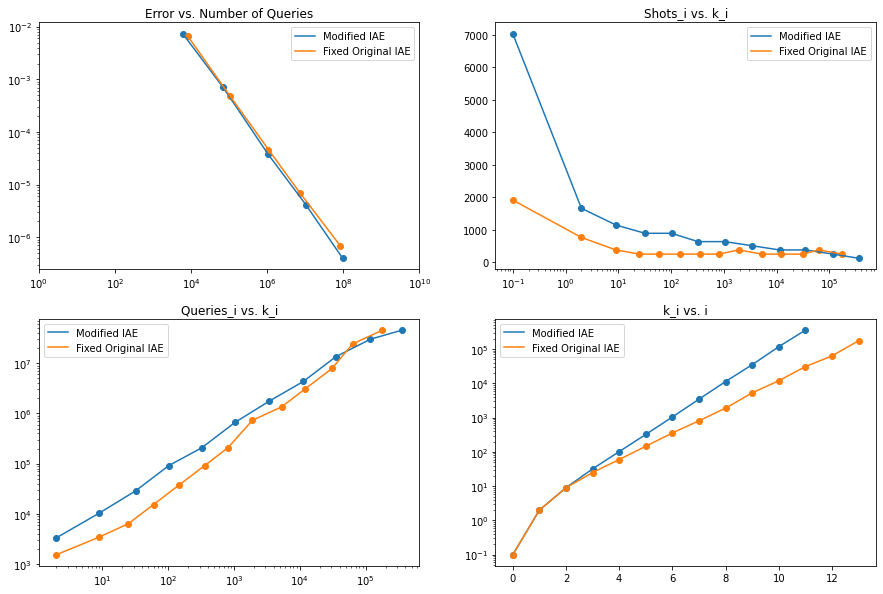

a: 14/16 = 0.875
Modified IAE estimations: [0.8749831808622686, 0.8747911787195746, 0.8749959971350536, 0.8749992074930689, 0.8750000624185762]
Fixed Original IAE estimations: [0.8749643877531963, 0.8750306317589145, 0.8750013077928755, 0.8750030258323125, 0.8750001307822446]
Modified IAE total queries: 98399104
Fixed Original IAE total queries: 97737728
Modified IAE epsilons: [0.0044850885792933615, 0.0005311932604608605, 4.6989297682209497e-05, 5.617157744719492e-06, 4.29291768466733e-07]
Fixed Original IAE epsilons: [0.0044658670517842, 0.0005235066597099602, 5.118353660193975e-05, 6.2630936093488465e-06, 5.508487341265855e-07]
Modified wins? True with 0.67% difference


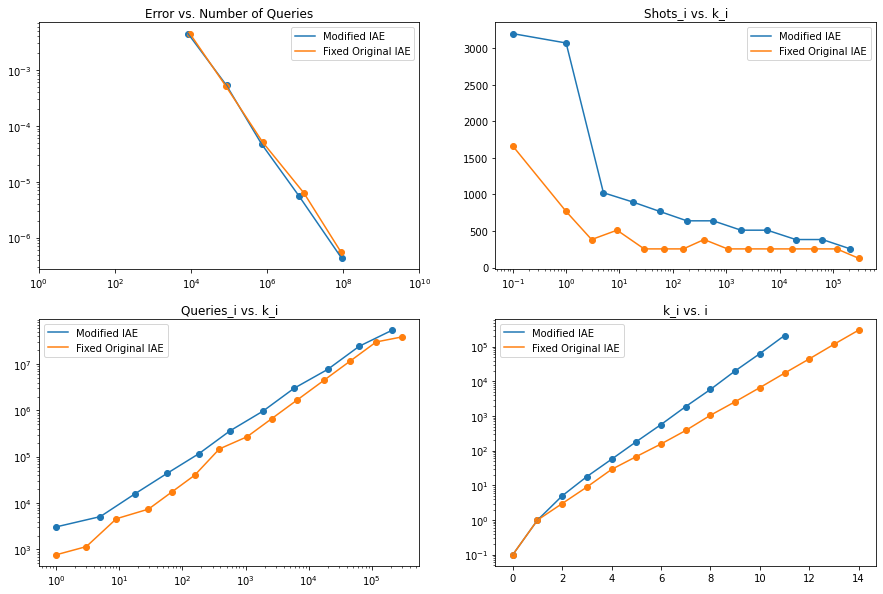

a: 15/16 = 0.9375
Modified IAE estimations: [0.9377035973300571, 0.9375166961831314, 0.9375063457295316, 0.937500491233914, 0.9374999408419976]
Fixed Original IAE estimations: [0.9365792545266971, 0.9374990935839244, 0.9374974374748997, 0.9374996317642215, 0.9374999581039698]
Modified IAE total queries: 88724480
Fixed Original IAE total queries: 91296896
Modified IAE epsilons: [0.003934634258316083, 0.0003448595807799548, 2.6763486412839654e-05, 3.320473433710003e-06, 4.13064530802032e-07]
Fixed Original IAE epsilons: [0.004592146410615172, 0.0002969464500179875, 4.7365024703927006e-05, 4.255501081684709e-06, 4.090721153482413e-07]
Modified wins? False with 2.9% difference


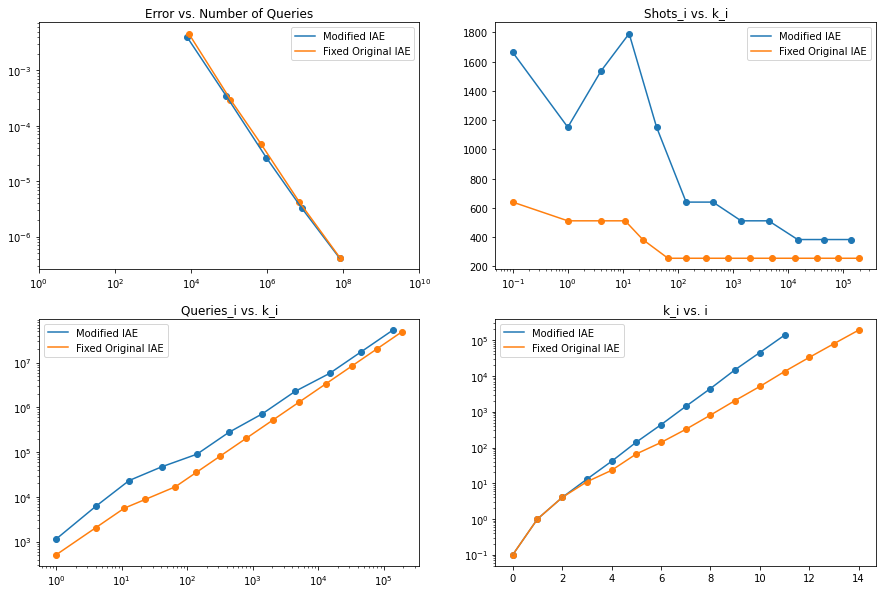

a: 16/16 = 1.0
Modified IAE estimations: [0.9998137089036647, 0.9999980141095087, 0.9999999816736711, 0.9999999998139724, 0.9999999999996455]
Fixed Original IAE estimations: [0.9998291335725844, 0.9999990134750827, 0.9999999933363806, 0.9999999999429342, 0.9999999999995798]
Modified IAE total queries: 103532288
Fixed Original IAE total queries: 91604096
Modified IAE epsilons: [0.0001862910963353337, 1.985890491273956e-06, 1.832632884335439e-08, 1.8602763773856168e-10, 3.544942117628125e-13]
Fixed Original IAE epsilons: [0.00017086642741565017, 9.865249173124369e-07, 6.663619434021939e-09, 5.7065796532640434e-11, 4.2021941482062175e-13]
Modified wins? True with 11.52% difference


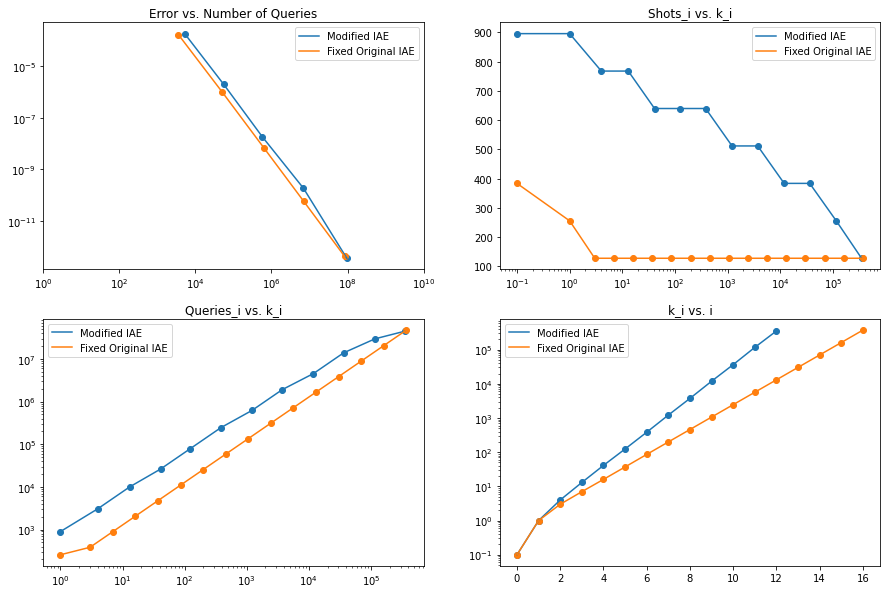

% modified > original: 0.29411764705882354


In [6]:
# stats recording
iae_epsilon = []
iae_nshots = []
miae_epsilon = []
miae_nshots = []

wins = matches = 0

ki = 0
while ki <= k:
    
    # setup problems with specified N,k
    N = 2**n
    marked = sample(range(N), ki)
    problem, problem2 = make_problems(n, marked)
    
    # execute experiments for each power
    miae_results = [] 
    iae_results = []
    
    for i, epsilon in enumerate(epsilons):
        if verbose:
            print('ε:',epsilon)
            
        MIAE = ModifiedIterativeAmplitudeEstimation(epsilon_target=epsilon, 
                                                    alpha=alpha, 
                                                    confint_method=confint_method, 
                                                    quantum_instance=aer_sim)
        
        IAE = IterativeAmplitudeEstimation(epsilon_target=epsilon, 
                                                    alpha=alpha, 
                                                    confint_method=confint_method, 
                                                    quantum_instance=aer_sim)
        
        exprs = ['Modified IAE', 'Fixed Original IAE']
        
        # configure the number of shots this way and pray that it works
        MIAE._quantum_instance._run_config.shots = shots
        IAE._quantum_instance._run_config.shots = shots
        
        # for recording intermediate algo results
        state = defaultdict(dict)
        state2 = defaultdict(dict)
        
        miae_result = MIAE.estimate(problem,
                                    state=state,
                                    verbose=verbose)
        
        iae_result = IAE.estimate(problem2,
                                  state=state2,
#                                   k0=ki,
#                                   N=N,
                                  verbose=verbose)
        
        miae_results.append(miae_result)
        iae_results.append(iae_result)
        if verbose:
            print()
    
    # process results
    miae_epsilon_i = [(res.confidence_interval_processed[1] - res.confidence_interval_processed[0]) / 2 for res in miae_results]
    miae_nshots_i  = [res.num_oracle_queries for res in miae_results]

    iae_epsilon_i = [(res.confidence_interval_processed[1] - res.confidence_interval_processed[0]) / 2 for res in iae_results]
    iae_nshots_i  = [res.num_oracle_queries for res in iae_results]
    
    print(f'a: {ki}/{N} = {ki/N}')
    print(f'{exprs[0]} estimations:', [res.estimation for res in miae_results])
    print(f'{exprs[1]} estimations:', [res.estimation for res in iae_results])
    
    miae_total_queries, iae_total_queries = sum(miae_nshots_i), sum(iae_nshots_i)
    print(f'{exprs[0]} total queries:', miae_total_queries)
    print(f'{exprs[1]} total queries:', iae_total_queries)
    
    print(f'{exprs[0]} epsilons:', miae_epsilon_i)
    print(f'{exprs[1]} epsilons:', iae_epsilon_i)
    
    diff = round(abs(iae_total_queries - miae_total_queries) / miae_total_queries * 100, 2)
    print('Modified wins?', iae_total_queries < miae_total_queries, f'with {diff}% difference')
    
    wins += int(iae_total_queries < miae_total_queries)
    matches += 1
    
    # graph k_i vs num_shots
    def process_state(state):
        if len(state) == 0: return [],[]
        round_shots = state['round_shots']
        queries = state['n_queries']
        shots_at_k0 = round_shots.pop(0)
        queries_at_k0 = queries.pop(0)
    
        k_i = [k for k in round_shots]
        queries_i = [queries[k] for k in k_i]
        shots_i = [shots_at_k0] + [round_shots[k] for k in k_i]
    
        k_i.insert(0, 0.1)
        
        return shots_i, queries_i, k_i
    
    mod_shots, mod_queries, mod_k = process_state(state)
    base_shots, base_queries, base_k = process_state(state2)

    fig,axs = plt.subplots(2,2,figsize=(15,10))
    
    # plot query complexity
    
    axs[0,0].set_yscale('log')
    axs[0,0].set_xscale('log')
    axs[0,0].set_xlim(1, 10**10)
    axs[0,0].set_title('Error vs. Number of Queries')
    
    axs[0,0].scatter(miae_nshots_i, miae_epsilon_i)
    axs[0,0].plot(miae_nshots_i, miae_epsilon_i)
    axs[0,0].scatter(iae_nshots_i, iae_epsilon_i)
    axs[0,0].plot(iae_nshots_i, iae_epsilon_i)
    
    axs[0,0].legend(exprs)
    
    # plots for shots vs k
    axs[0,1].set_xscale('log')
    axs[0,1].set_title('Shots_i vs. k_i')
    
    axs[0,1].plot(mod_k, mod_shots)
    axs[0,1].scatter(mod_k, mod_shots)
    axs[0,1].plot(base_k, base_shots)
    axs[0,1].scatter(base_k, base_shots)
    
    axs[0,1].legend(exprs)
    
    # plots for nqueries vs k
    axs[1,0].set_xscale('log')
    axs[1,0].set_yscale('log')
    axs[1,0].set_title('Queries_i vs. k_i')
    
    axs[1,0].plot(mod_k[1:], mod_queries)
    axs[1,0].scatter(mod_k[1:], mod_queries)
    axs[1,0].plot(base_k[1:], base_queries)
    axs[1,0].scatter(base_k[1:], base_queries)
    
    axs[1,0].legend(exprs)
    
    # plots for k
    axs[1,1].set_yscale('log')
    axs[1,1].set_title('k_i vs. i')
    
    axs[1,1].plot(mod_k)
    axs[1,1].scatter(range(len(mod_k)), mod_k)
    axs[1,1].plot(base_k)
    axs[1,1].scatter(range(len(base_k)), base_k)
    
    axs[1,1].legend(exprs)
    
    plt.show()
    
    # save results for epsilon vs nshots
    miae_nshots.append(miae_nshots_i)
    miae_epsilon.append(miae_epsilon_i)
    iae_nshots.append(iae_nshots_i)
    iae_epsilon.append(iae_epsilon_i)
    
    ki += 1
    
iae_nshots = np.array(iae_nshots)
print('% modified > original:', wins/matches)

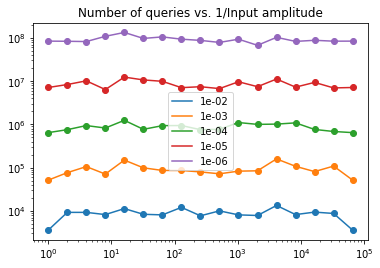

In [7]:
for i in range(len(epsilons)):
    plt.plot(2**np.arange(iae_nshots.shape[0]), iae_nshots[:,i])
    plt.scatter(2**np.arange(iae_nshots.shape[0]), iae_nshots[:,i])

plt.title('Number of queries vs. 1/Input amplitude')
plt.legend(['{:.0e}'.format(eps) for eps in epsilons])
plt.xscale('log')
plt.yscale('log')

plt.show()